/tmp/ipykernel_948893/3626526482.py:44: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)


Normalized sparse matrix shape: (12989, 132763)
Starting Epoch 1/15...
Epoch 1/15, Training Loss: 21.103193858953624, Validation Loss: 8.836785477858323
Starting Epoch 2/15...
Epoch 2/15, Training Loss: 4.238020649552345, Validation Loss: 9.640355506310096
Starting Epoch 3/15...
Epoch 3/15, Training Loss: 1.9027205627698165, Validation Loss: 5.654598327783438
Starting Epoch 4/15...
Epoch 4/15, Training Loss: 1.1643184663011477, Validation Loss: 4.352537815387432
Starting Epoch 5/15...
Epoch 5/15, Training Loss: 0.9154745267560849, Validation Loss: 3.62450799208421
Starting Epoch 6/15...
Epoch 6/15, Training Loss: 0.768771309692126, Validation Loss: 3.557304565723126
Starting Epoch 7/15...
Epoch 7/15, Training Loss: 0.6484839234787684, Validation Loss: 3.855642164670504
Starting Epoch 8/15...
Epoch 8/15, Training Loss: 0.5937475693913606, Validation Loss: 3.1491268964914174
Starting Epoch 9/15...
Epoch 9/15, Training Loss: 0.5326066348415155, Validation Loss: 3.1583637255888717
Starting

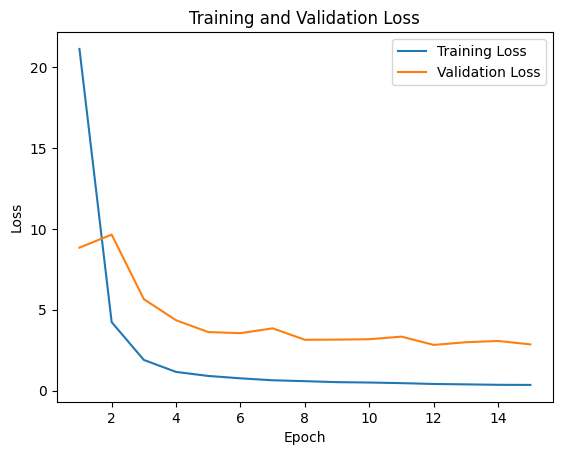

Test Loss: 2.763978057518238
Precision: 1.0, Recall: 1.0, F1 Score: 1.0, ROC-AUC: undefined (only one class present in y_true)


In [27]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

data = pd.read_csv('filtered_dataset (1).csv')
data = data[['paper_id', 'publication_year', 'concept', 'concept_no', 'npaper_ids_using_concept']]
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)


label_encoder = LabelEncoder()
data['concept_encoded'] = label_encoder.fit_transform(data['concept'])


data['year_category'] = pd.cut(
    data['publication_year'], bins=[1990, 2000, 2010, 2020, 2030], labels=False
)


concept_count = data.groupby('concept_encoded')['paper_id'].count().reset_index(name='concept_count')
data = pd.merge(data, concept_count, on='concept_encoded')


H = nx.Graph()
for _, row in data.iterrows():
    paper_id = row['paper_id']
    concept = row['concept_encoded']
    H.add_node(paper_id)
    H.add_node(concept)
    H.add_edge(paper_id, concept)


nodelist = np.unique(data[['paper_id', 'concept_encoded']].values.flatten())
incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)


if not isinstance(incidence_matrix_sparse, csr_matrix):
    incidence_matrix_sparse = csr_matrix(incidence_matrix_sparse)


scaler = MaxAbsScaler()
X = scaler.fit_transform(incidence_matrix_sparse)  
print(f"Normalized sparse matrix shape: {X.shape}")


y = data['concept_count'].values[:X.shape[0]]
y = np.log1p(y)  


class SparseHypergraphDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
       
        row_dense = self.X[idx, :].toarray().squeeze()
        return torch.FloatTensor(row_dense), torch.FloatTensor([self.y[idx]])


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

train_data = SparseHypergraphDataset(X_train, y_train)
val_data = SparseHypergraphDataset(X_val, y_val)
test_data = SparseHypergraphDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


class HNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HNN_LSTM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc2(x[:, -1, :])
        return x


input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 1
model = HNN_LSTM(input_dim, hidden_dim, output_dim)


optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.MSELoss()


def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=15):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}...")  
        model.train()
        epoch_train_loss = 0  
        
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() 

       
        epoch_train_loss /= len(train_loader)
        training_losses.append(epoch_train_loss)

        
        model.eval()
        epoch_val_loss = 0  
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                epoch_val_loss += loss.item()  

       
        epoch_val_loss /= len(val_loader)
        validation_losses.append(epoch_val_loss)

        
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

    print("Training complete!")  
    return training_losses, validation_losses


training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=15)


plt.plot(range(1, 16), training_losses, label='Training Loss')
plt.plot(range(1, 16), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            all_preds.extend(y_pred.squeeze().tolist())
            all_targets.extend(y_batch.squeeze().tolist())
    return total_loss, all_preds, all_targets

total_loss, all_preds, all_targets = evaluate_model(model, test_loader, criterion)


all_preds_binary = [1 if pred > 0.5 else 0 for pred in all_preds]
all_targets_binary = [1 if target > 0.5 else 0 for target in all_targets]


precision = precision_score(all_targets_binary, all_preds_binary, zero_division=0)
recall = recall_score(all_targets_binary, all_preds_binary, zero_division=0)
f1 = f1_score(all_targets_binary, all_preds_binary, zero_division=0)
roc_auc = (
    roc_auc_score(all_targets_binary, all_preds)
    if len(np.unique(all_targets_binary)) > 1
    else "undefined (only one class present in y_true)"
)


print(f"Test Loss: {total_loss / len(test_loader)}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC-AUC: {roc_auc}")


In [28]:
# Increase Droupout Rate, Early Stopping, Learning Rate Scheduler

/tmp/ipykernel_948893/459078451.py:45: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)


Normalized sparse matrix shape: (12989, 132763)
Starting Epoch 1/15...
Epoch 1/15, Training Loss: 5.413902141497686, Validation Loss: 2.6731207058979916
Starting Epoch 2/15...
Epoch 2/15, Training Loss: 1.382282120333268, Validation Loss: 1.023032121016429
Starting Epoch 3/15...
Epoch 3/15, Training Loss: 0.8330612767201203, Validation Loss: 1.0169772909237789
Starting Epoch 4/15...
Epoch 4/15, Training Loss: 0.6240896898966569, Validation Loss: 1.0270360763256365
Starting Epoch 5/15...
Epoch 5/15, Training Loss: 0.5126072089259441, Validation Loss: 1.046557221045861
Starting Epoch 6/15...
Epoch 6/15, Training Loss: 0.44862183699241054, Validation Loss: 1.054517506636106
Early stopping at epoch 6
Training complete!


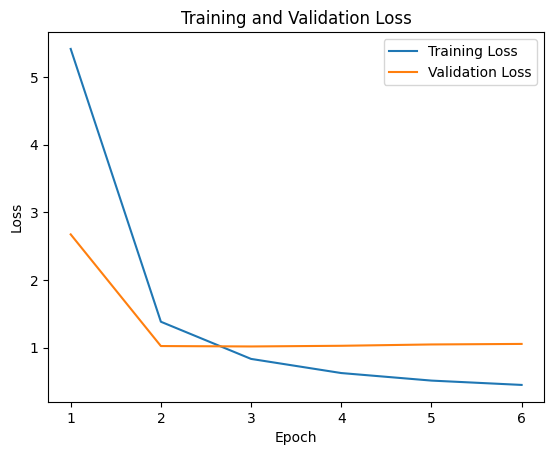

Test Loss: 1.0319033315995845
Precision: 1.0, Recall: 1.0, F1 Score: 1.0, ROC-AUC: undefined (only one class present in y_true)


In [29]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


data = pd.read_csv('filtered_dataset (1).csv')
data = data[['paper_id', 'publication_year', 'concept', 'concept_no', 'npaper_ids_using_concept']]
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)


label_encoder = LabelEncoder()
data['concept_encoded'] = label_encoder.fit_transform(data['concept'])


data['year_category'] = pd.cut(
    data['publication_year'], bins=[1990, 2000, 2010, 2020, 2030], labels=False
)


concept_count = data.groupby('concept_encoded')['paper_id'].count().reset_index(name='concept_count')
data = pd.merge(data, concept_count, on='concept_encoded')


H = nx.Graph()
for _, row in data.iterrows():
    paper_id = row['paper_id']
    concept = row['concept_encoded']
    H.add_node(paper_id)
    H.add_node(concept)
    H.add_edge(paper_id, concept)


nodelist = np.unique(data[['paper_id', 'concept_encoded']].values.flatten())
incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)


if not isinstance(incidence_matrix_sparse, csr_matrix):
    incidence_matrix_sparse = csr_matrix(incidence_matrix_sparse)


scaler = MaxAbsScaler()
X = scaler.fit_transform(incidence_matrix_sparse)  
print(f"Normalized sparse matrix shape: {X.shape}")


y = data['concept_count'].values[:X.shape[0]]
y = np.log1p(y) 


class SparseHypergraphDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        
        row_dense = self.X[idx, :].toarray().squeeze()
        return torch.FloatTensor(row_dense), torch.FloatTensor([self.y[idx]])


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

train_data = SparseHypergraphDataset(X_train, y_train)
val_data = SparseHypergraphDataset(X_val, y_val)
test_data = SparseHypergraphDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


class HNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HNN_LSTM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.4)  # Increased dropout for regularization
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc2(x[:, -1, :])
        return x


input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 1
model = HNN_LSTM(input_dim, hidden_dim, output_dim)


optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


early_stopping_patience = 3
best_val_loss = float('inf')
early_stopping_counter = 0


def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=15):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}...")
        model.train()
        epoch_train_loss = 0
        
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

       
        epoch_train_loss /= len(train_loader)
        training_losses.append(epoch_train_loss)

       
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                epoch_val_loss += loss.item()

      
        epoch_val_loss /= len(val_loader)
        validation_losses.append(epoch_val_loss)

       
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

       
        scheduler.step(epoch_val_loss)

     
        global best_val_loss, early_stopping_counter
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), "best_model.pt")  # Save the best model
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print("Training complete!")
    return training_losses, validation_losses


training_losses, validation_losses = train_model(
    model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=15
)


plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            all_preds.extend(y_pred.squeeze().tolist())
            all_targets.extend(y_batch.squeeze().tolist())
    return total_loss, all_preds, all_targets


model.load_state_dict(torch.load("best_model.pt"))
total_loss, all_preds, all_targets = evaluate_model(model, test_loader, criterion)


all_preds_binary = [1 if pred > 0.5 else 0 for pred in all_preds]
all_targets_binary = [1 if target > 0.5 else 0 for target in all_targets]


precision = precision_score(all_targets_binary, all_preds_binary, zero_division=0)
recall = recall_score(all_targets_binary, all_preds_binary, zero_division=0)
f1 = f1_score(all_targets_binary, all_preds_binary, zero_division=0)
roc_auc = (
    roc_auc_score(all_targets_binary, all_preds)
    if len(np.unique(all_targets_binary)) > 1
    else "undefined (only one class present in y_true)"
)


print(f"Test Loss: {total_loss / len(test_loader)}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC-AUC: {roc_auc}")


/tmp/ipykernel_948893/2402802930.py:46: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)


Normalized sparse matrix shape: (12989, 132763)
Starting Epoch 1/15...
Epoch 1/15, Training Loss: 1.4149711261459927, Validation Loss: 1.1635849342896387
Starting Epoch 2/15...
Epoch 2/15, Training Loss: 0.3930343117622877, Validation Loss: 1.0518454102369454
Starting Epoch 3/15...
Epoch 3/15, Training Loss: 0.25826041037914943, Validation Loss: 1.1008135832273043
Starting Epoch 4/15...
Epoch 4/15, Training Loss: 0.22202924218508277, Validation Loss: 1.0600572659419134
Starting Epoch 5/15...
Epoch 5/15, Training Loss: 0.2117030524676389, Validation Loss: 1.0487395621263065
Starting Epoch 6/15...
Epoch 6/15, Training Loss: 0.20435595069781387, Validation Loss: 1.1115568711207464
Starting Epoch 7/15...
Epoch 7/15, Training Loss: 0.19890998216949224, Validation Loss: 1.0649257623232329
Starting Epoch 8/15...
Epoch 8/15, Training Loss: 0.19466751190547896, Validation Loss: 1.087767065488375
Early stopping at epoch 8
Training complete!


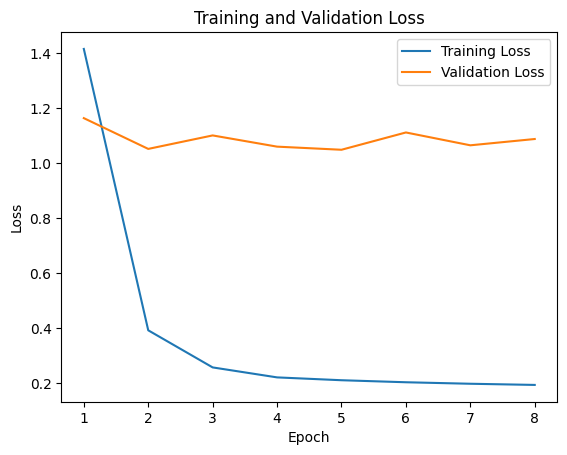

Test Loss: 1.055096471818482
Precision: 1.0, Recall: 1.0, F1 Score: 1.0, ROC-AUC: undefined (only one class present in y_true)

Confusion Matrix:
[[2598]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2598

    accuracy                           1.00      2598
   macro avg       1.00      1.00      1.00      2598
weighted avg       1.00      1.00      1.00      2598



In [35]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


data = pd.read_csv('filtered_dataset (1).csv')
data = data[['paper_id', 'publication_year', 'concept', 'concept_no', 'npaper_ids_using_concept']]
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)


label_encoder = LabelEncoder()
data['concept_encoded'] = label_encoder.fit_transform(data['concept'])


data['year_category'] = pd.cut(
    data['publication_year'], bins=[1990, 2000, 2010, 2020, 2030], labels=False
)


concept_count = data.groupby('concept_encoded')['paper_id'].count().reset_index(name='concept_count')
data = pd.merge(data, concept_count, on='concept_encoded')


H = nx.Graph()
for _, row in data.iterrows():
    paper_id = row['paper_id']
    concept = row['concept_encoded']
    H.add_node(paper_id)
    H.add_node(concept)
    H.add_edge(paper_id, concept)


nodelist = np.unique(data[['paper_id', 'concept_encoded']].values.flatten())
incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)


if not isinstance(incidence_matrix_sparse, csr_matrix):
    incidence_matrix_sparse = csr_matrix(incidence_matrix_sparse)


scaler = MaxAbsScaler()
X = scaler.fit_transform(incidence_matrix_sparse)  
print(f"Normalized sparse matrix shape: {X.shape}")


y = data['concept_count'].values[:X.shape[0]]
y = np.log1p(y) 


bins = np.linspace(min(y), max(y), 5)  
y_binned = np.digitize(y, bins) - 1  


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_binned, test_size=0.2, stratify=y_binned, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)


smote = SMOTE(random_state=42)
X_train_sm, y_train_sm_binned = smote.fit_resample(X_train.toarray(), y_train)


y_train_sm = bins[y_train_sm_binned]


class SparseHypergraphDataset(Dataset):
    def __init__(self, X, y):
        self.X = csr_matrix(X)  
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        row_dense = self.X[idx, :].toarray().squeeze()
        return torch.FloatTensor(row_dense), torch.FloatTensor([self.y[idx]])


train_data = SparseHypergraphDataset(X_train_sm, y_train_sm)
val_data = SparseHypergraphDataset(X_val.toarray(), bins[y_val])  # Convert binned validation back to continuous
test_data = SparseHypergraphDataset(X_test.toarray(), bins[y_test])  # Convert binned test back to continuous

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


class HNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HNN_LSTM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.4)  # Increased dropout for regularization
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc2(x[:, -1, :])
        return x


input_dim = X_train_sm.shape[1]
hidden_dim = 128
output_dim = 1
model = HNN_LSTM(input_dim, hidden_dim, output_dim)


optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


early_stopping_patience = 3
best_val_loss = float('inf')
early_stopping_counter = 0


def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=15):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}...")
        model.train()
        epoch_train_loss = 0
        
    
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

      
        epoch_train_loss /= len(train_loader)
        training_losses.append(epoch_train_loss)

  
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                epoch_val_loss += loss.item()

       
        epoch_val_loss /= len(val_loader)
        validation_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

   
        scheduler.step(epoch_val_loss)

   
        global best_val_loss, early_stopping_counter
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), "best_model.pt")  
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print("Training complete!")
    return training_losses, validation_losses


training_losses, validation_losses = train_model(
    model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=15
)


plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            all_preds.extend(y_pred.squeeze().tolist())
            all_targets.extend(y_batch.squeeze().tolist())
    return total_loss, all_preds, all_targets


model.load_state_dict(torch.load("best_model.pt"))
total_loss, all_preds, all_targets = evaluate_model(model, test_loader, criterion)


all_preds_binary = [1 if pred > 0.5 else 0 for pred in all_preds]
all_targets_binary = [1 if target > 0.5 else 0 for target in all_targets]


precision = precision_score(all_targets_binary, all_preds_binary, zero_division=0)
recall = recall_score(all_targets_binary, all_preds_binary, zero_division=0)
f1 = f1_score(all_targets_binary, all_preds_binary, zero_division=0)
roc_auc = (
    roc_auc_score(all_targets_binary, all_preds)
    if len(np.unique(all_targets_binary)) > 1
    else "undefined (only one class present in y_true)"
)


print(f"Test Loss: {total_loss / len(test_loader)}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC-AUC: {roc_auc}")


print("\nConfusion Matrix:")
print(confusion_matrix(all_targets_binary, all_preds_binary))
print("\nClassification Report:")
print(classification_report(all_targets_binary, all_preds_binary))


/tmp/ipykernel_948893/3129367716.py:39: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)


Starting Epoch 1/15...
Epoch 1/15, Training Loss: 1.3315631569991524, Validation Loss: 1.0353204543773944
Starting Epoch 2/15...
Epoch 2/15, Training Loss: 0.39974352531925456, Validation Loss: 1.0222149793918316
Starting Epoch 3/15...
Epoch 3/15, Training Loss: 0.24777353485411263, Validation Loss: 1.015019791859847
Starting Epoch 4/15...
Epoch 4/15, Training Loss: 0.21142225541817247, Validation Loss: 1.053490926669194
Starting Epoch 5/15...
Epoch 5/15, Training Loss: 0.19673459796706555, Validation Loss: 1.0956713795661925
Starting Epoch 6/15...
Epoch 6/15, Training Loss: 0.19709263977501146, Validation Loss: 1.1191150995401236
Early stopping at epoch 6


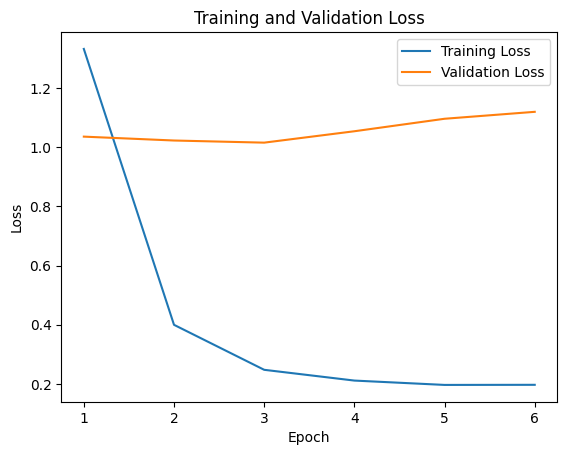

Test Loss: 1.0072948867227973
Precision: 1.0, Recall: 1.0, F1 Score: 1.0, ROC-AUC: undefined (only one class present in y_true)

Confusion Matrix:
[[2598]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2598

    accuracy                           1.00      2598
   macro avg       1.00      1.00      1.00      2598
weighted avg       1.00      1.00      1.00      2598



In [36]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Data Preprocessing
data = pd.read_csv('filtered_dataset (1).csv')
data = data[['paper_id', 'publication_year', 'concept', 'concept_no', 'npaper_ids_using_concept']]
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

# Encoding and Feature Engineering
label_encoder = LabelEncoder()
data['concept_encoded'] = label_encoder.fit_transform(data['concept'])
data['year_category'] = pd.cut(data['publication_year'], bins=[1990, 2000, 2010, 2020, 2030], labels=False)
concept_count = data.groupby('concept_encoded')['paper_id'].count().reset_index(name='concept_count')
data = pd.merge(data, concept_count, on='concept_encoded')

# Hypergraph Construction
H = nx.Graph()
for _, row in data.iterrows():
    paper_id = row['paper_id']
    concept = row['concept_encoded']
    H.add_node(paper_id)
    H.add_node(concept)
    H.add_edge(paper_id, concept)

nodelist = np.unique(data[['paper_id', 'concept_encoded']].values.flatten())
incidence_matrix_sparse = nx.incidence_matrix(H, nodelist=nodelist)

# Ensure Sparse Representation and Normalization
if not isinstance(incidence_matrix_sparse, csr_matrix):
    incidence_matrix_sparse = csr_matrix(incidence_matrix_sparse)
scaler = MaxAbsScaler()
X = scaler.fit_transform(incidence_matrix_sparse)

# Target Log Transformation
y = np.log1p(data['concept_count'].values[:X.shape[0]])

# Stratified Splits and SMOTE
bins = np.linspace(min(y), max(y), 5)
y_binned = np.digitize(y, bins) - 1
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_binned, test_size=0.2, stratify=y_binned, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm_binned = smote.fit_resample(X_train.toarray(), y_train)
y_train_sm = bins[y_train_sm_binned]

# Custom Dataset Class
class SparseHypergraphDataset(Dataset):
    def __init__(self, X, y):
        self.X = csr_matrix(X)
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        row_dense = self.X[idx, :].toarray().squeeze()
        return torch.FloatTensor(row_dense), torch.FloatTensor([self.y[idx]])

train_data = SparseHypergraphDataset(X_train_sm, y_train_sm)
val_data = SparseHypergraphDataset(X_val.toarray(), bins[y_val])
test_data = SparseHypergraphDataset(X_test.toarray(), bins[y_test])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model Definition
class HNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HNN_LSTM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc2(x[:, -1, :])
        return x

input_dim = X_train_sm.shape[1]
hidden_dim = 128
output_dim = 1
model = HNN_LSTM(input_dim, hidden_dim, output_dim)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training Loop with Early Stopping
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=15):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 3

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}...")
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader)
        training_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader)
        validation_losses.append(epoch_val_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

        scheduler.step(epoch_val_loss)
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return training_losses, validation_losses

training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler)

# Plot Losses
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate Model
model.load_state_dict(torch.load("best_model.pt"))
total_loss, all_preds, all_targets = evaluate_model(model, test_loader, criterion)

# Metrics and Classification Report
all_preds_binary = [1 if pred > 0.5 else 0 for pred in all_preds]
all_targets_binary = [1 if target > 0.5 else 0 for target in all_targets]
precision = precision_score(all_targets_binary, all_preds_binary, zero_division=0)
recall = recall_score(all_targets_binary, all_preds_binary, zero_division=0)
f1 = f1_score(all_targets_binary, all_preds_binary, zero_division=0)
roc_auc = (
    roc_auc_score(all_targets_binary, all_preds)
    if len(np.unique(all_targets_binary)) > 1
    else "undefined (only one class present in y_true)"
)
print(f"Test Loss: {total_loss / len(test_loader)}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC-AUC: {roc_auc}")
print("\nConfusion Matrix:")
print(confusion_matrix(all_targets_binary, all_preds_binary))
print("\nClassification Report:")
print(classification_report(all_targets_binary, all_preds_binary))


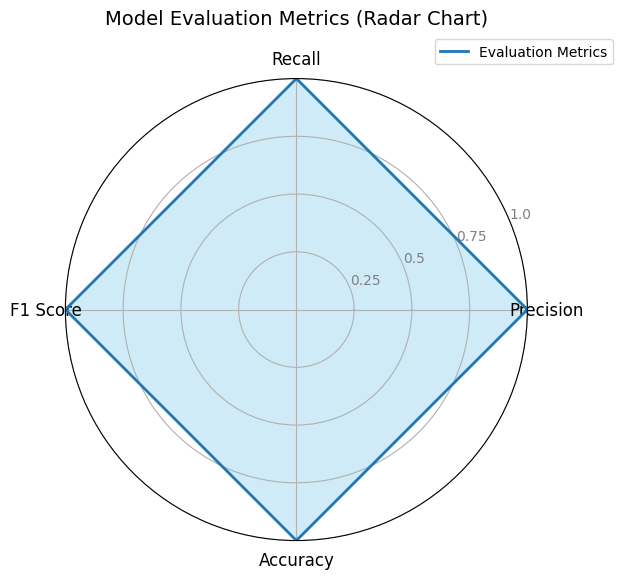

In [38]:
import matplotlib.pyplot as plt
from math import pi

metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]
values = [1.0, 1.0, 1.0, 1.0]  # Example scores
values += values[:1]  # Closing the radar chart


angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]  # Closing the radar chart


plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], metrics, color='black', size=12)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.5", "0.75", "1.0"], color="grey", size=10)
plt.ylim(0, 1)


ax.plot(angles, values, linewidth=2, linestyle='solid', label="Evaluation Metrics")
ax.fill(angles, values, color="skyblue", alpha=0.4)

plt.title("Model Evaluation Metrics (Radar Chart)", size=14, y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))


plt.show()
